 # Predicting the 2016 US Election Results in Hindsight 
 
 
 
 Testing something **bold** *italic* 
 

/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


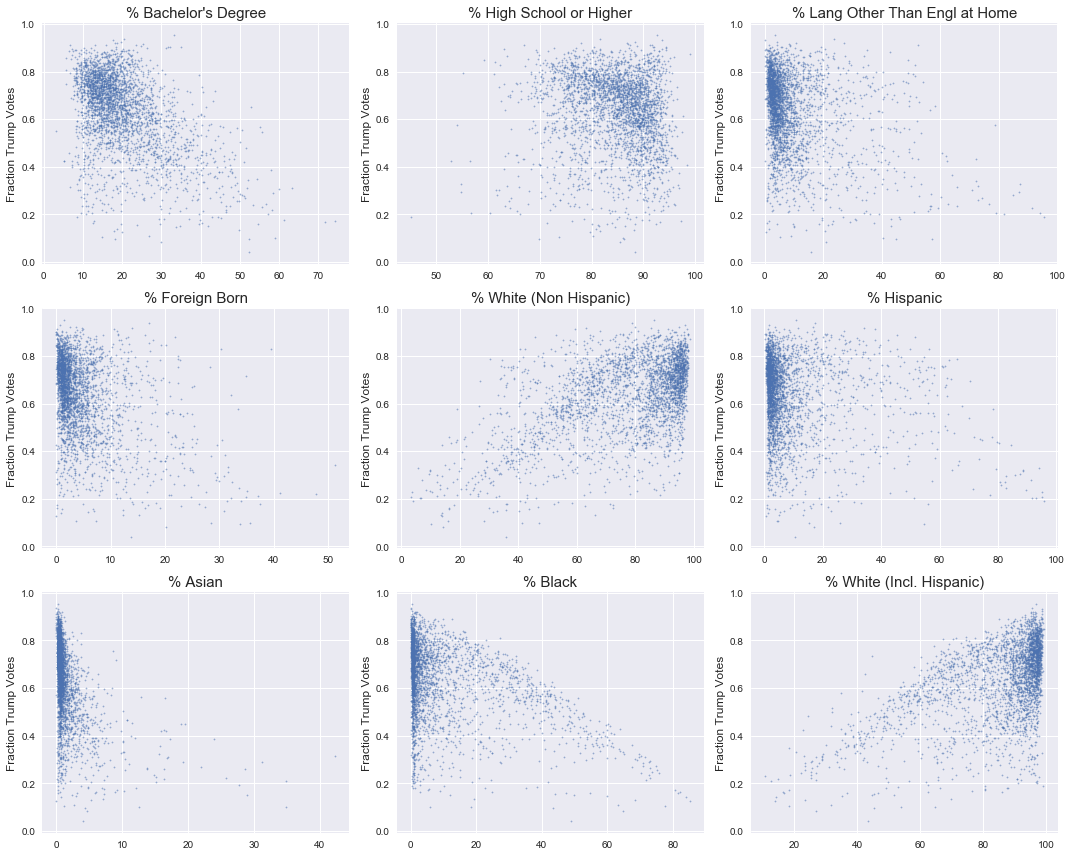

In [91]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy    
from matplotlib import patches

import seaborn as sns
    
results = pd.read_csv('pres16results.csv')
counties = pd.read_csv('county_facts (1).csv')

excl_list = ['US', 'CA', 'FL', 'TX', 'NY', 'PA', 'IL', 'OH', 'MI', 'NC', 'GA', 'VA', 'NJ', 'MA', 'WI', 'MN', 'MO', 'WA', 'IN', 'CO', 'TN', 'MD', 'SC', 'AL', 'AZ', 'LA', 'KY', 'OR', 'CT', 'IA', 'OK', 'MS', 'NV', 'AR', 'UT', 'NE', 'NM', 'ME', 'NH', 'WV', 'ID', 'MT', 'KS', 'RI', 'DE', 'HI', 'SD', 'ND', 'VT', 'DC', 'WY', 'AK'] 

county_dict = {'EDU685213' : '% Bachelor\'s Degree', 'EDU635213' : '% High School or Higher', 'POP815213' : '% Lang Other Than Engl at Home', 'POP645213' : '% Foreign Born', 'RHI825214' : '% White (Non Hispanic)', 'RHI725214' : '% Hispanic', 'RHI425214' : '% Asian', 'RHI225214' : '% Black', 'RHI125214' : '% White (Incl. Hispanic)'}

for state in excl_list:
    results = results[results.fips != state]

counties['fips'] = counties['fips'].astype(int)
results['fips'] = results['fips'].astype(int)

merged = pd.merge(left=counties,right=results, how='inner', left_on='fips', right_on='fips')
#print(merged[merged.cand == "Donald Trump"])
#print(merged[merged.cand == "Donald Trump"].pct.values)


demo = merged[['fips', 'cand', 'pct', 'EDU685213', 'EDU635213', 'POP815213', 'POP645213', 'RHI825214', 'RHI725214', 'RHI425214', 'RHI225214', 'RHI125214']]

# only the rows that have Trump as candidate

trump = demo[demo.cand == 'Donald Trump']
hillary = demo[demo.cand == 'Hillary Clinton']

del trump['cand']
del trump['fips']

names = trump.columns.values

#plt.scatter(trump.RHI125214.values, trump.pct.values, alpha = 0.3, s=1)
#plt.show()
#print(pearsonr(merged[merged['cand'] == 'Donald Trump'].RHI125214.values, merged[merged['cand'] == 'Donald Trump'].pct.values))

test = merged[merged['cand'] == 'Donald Trump']

# Rename columns values to something more meaningful
trump.rename(columns = county_dict, inplace = True)

# draw every county as a point in scatter plot. color red if Trump won, blue if Hillary won. x axis: white alone, y axis: foreign born
#plt.scatter(trump[trump['pct'] > 0.5].EDU685213.values, trump[trump['pct'] > 0.5].POP645213.values, alpha = 0.3, color = 'blue')
#plt.scatter(trump[trump['pct'] < 0.5].EDU685213.values, trump[trump['pct'] < 0.5].POP645213.values, alpha = 0.3, color = 'red')

plt.figure(figsize=(15, 12))
for ii, col in enumerate(trump.columns[1:10]):
    plt.subplot(3, 3, ii+1)
    plt.tick_params(labelsize = 10)
    plt.title(col, fontsize = 15)
    #plt.legend(handles = [patches.Patch(label = 'Malignant', color='red'),
    #                      patches.Patch(label = 'Benign', color='blue')])
    #b = df[df['diagnosis'] == 'B'][col]
    #m = df[df['diagnosis'] == 'M'][col]
    plt.scatter(trump[col], trump['pct'], alpha = 0.5, s = 1.8)
    plt.ylabel('Fraction Trump Votes', fontsize=12)
    #plt.hist(m, stacked=True, normed = True, color='red', alpha = 0.4)
    #plt.hist(b, stacked=True, normed = True, color='blue', alpha = 0.4)
    
plt.tight_layout()

Seems like the is a pretty good correlation between some 

In [ ]:
trump['win'] = 0
trump['win'][trump['pct'] > 0.45] = 1
trump['win'][trump['pct'] < 0.45] = 0


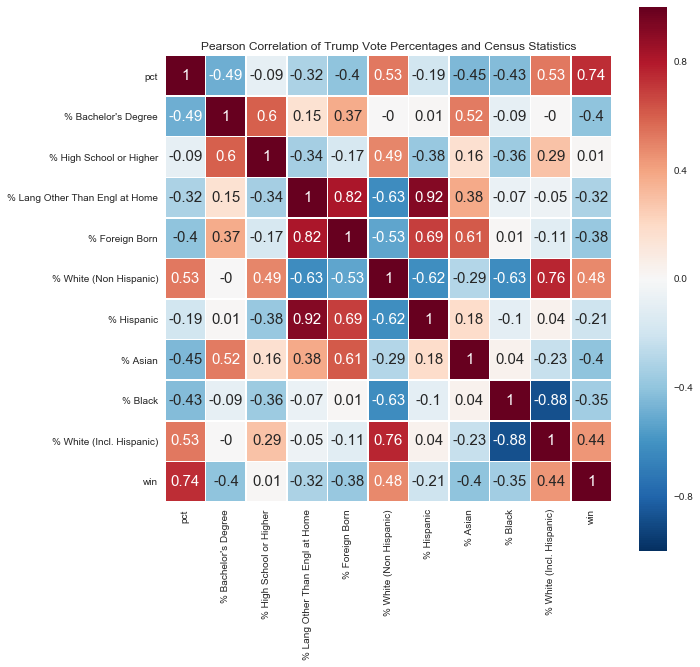

In [116]:
f, ax = plt.subplots(figsize=(10, 10))

plt.title('Pearson Correlation of Trump Vote Percentages and Census Statistics')
sns.set(font_scale=1)
sns.heatmap(trump.astype(float).corr().round(decimals = 2), linewidths = 0.5, vmax = 1.0, square = True, 
            annot = True, annot_kws={"size": 15})


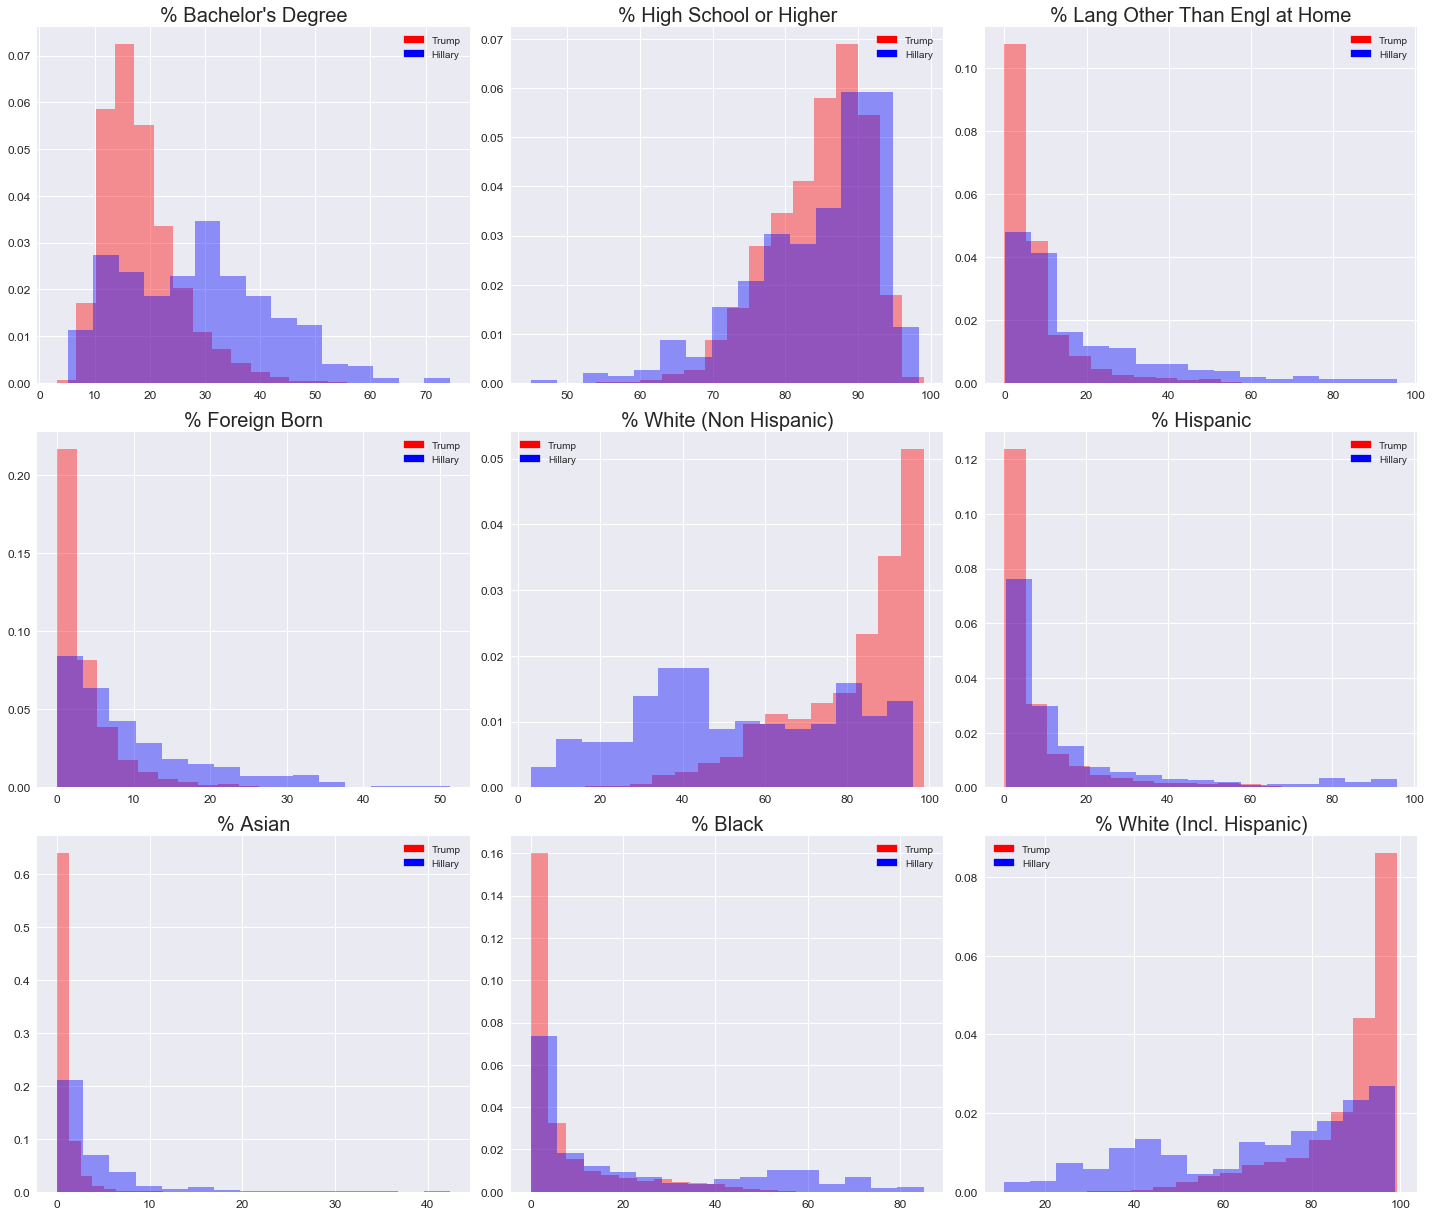

In [92]:
plt.figure(figsize=(20, 17))
for ii, col in enumerate(trump.columns[1:10]):
    plt.subplot(3 ,3, ii+1)
    plt.tick_params(labelsize = 12)
    plt.title(col, fontsize = 20)
    
    plt.legend(handles = [patches.Patch(label = 'Trump', color='red'),
                          patches.Patch(label = 'Hillary', color='blue')])
    trumpwin = trump[trump['pct'] > 0.45][col]
    hillarywin = trump[trump['pct'] < 0.45][col]
    plt.hist(trumpwin, stacked=True, normed = True, color='red', alpha = 0.4, bins = 15)
    plt.hist(hillarywin, stacked=True, normed = True, color='blue', alpha = 0.4, bins = 15)
    
plt.tight_layout()

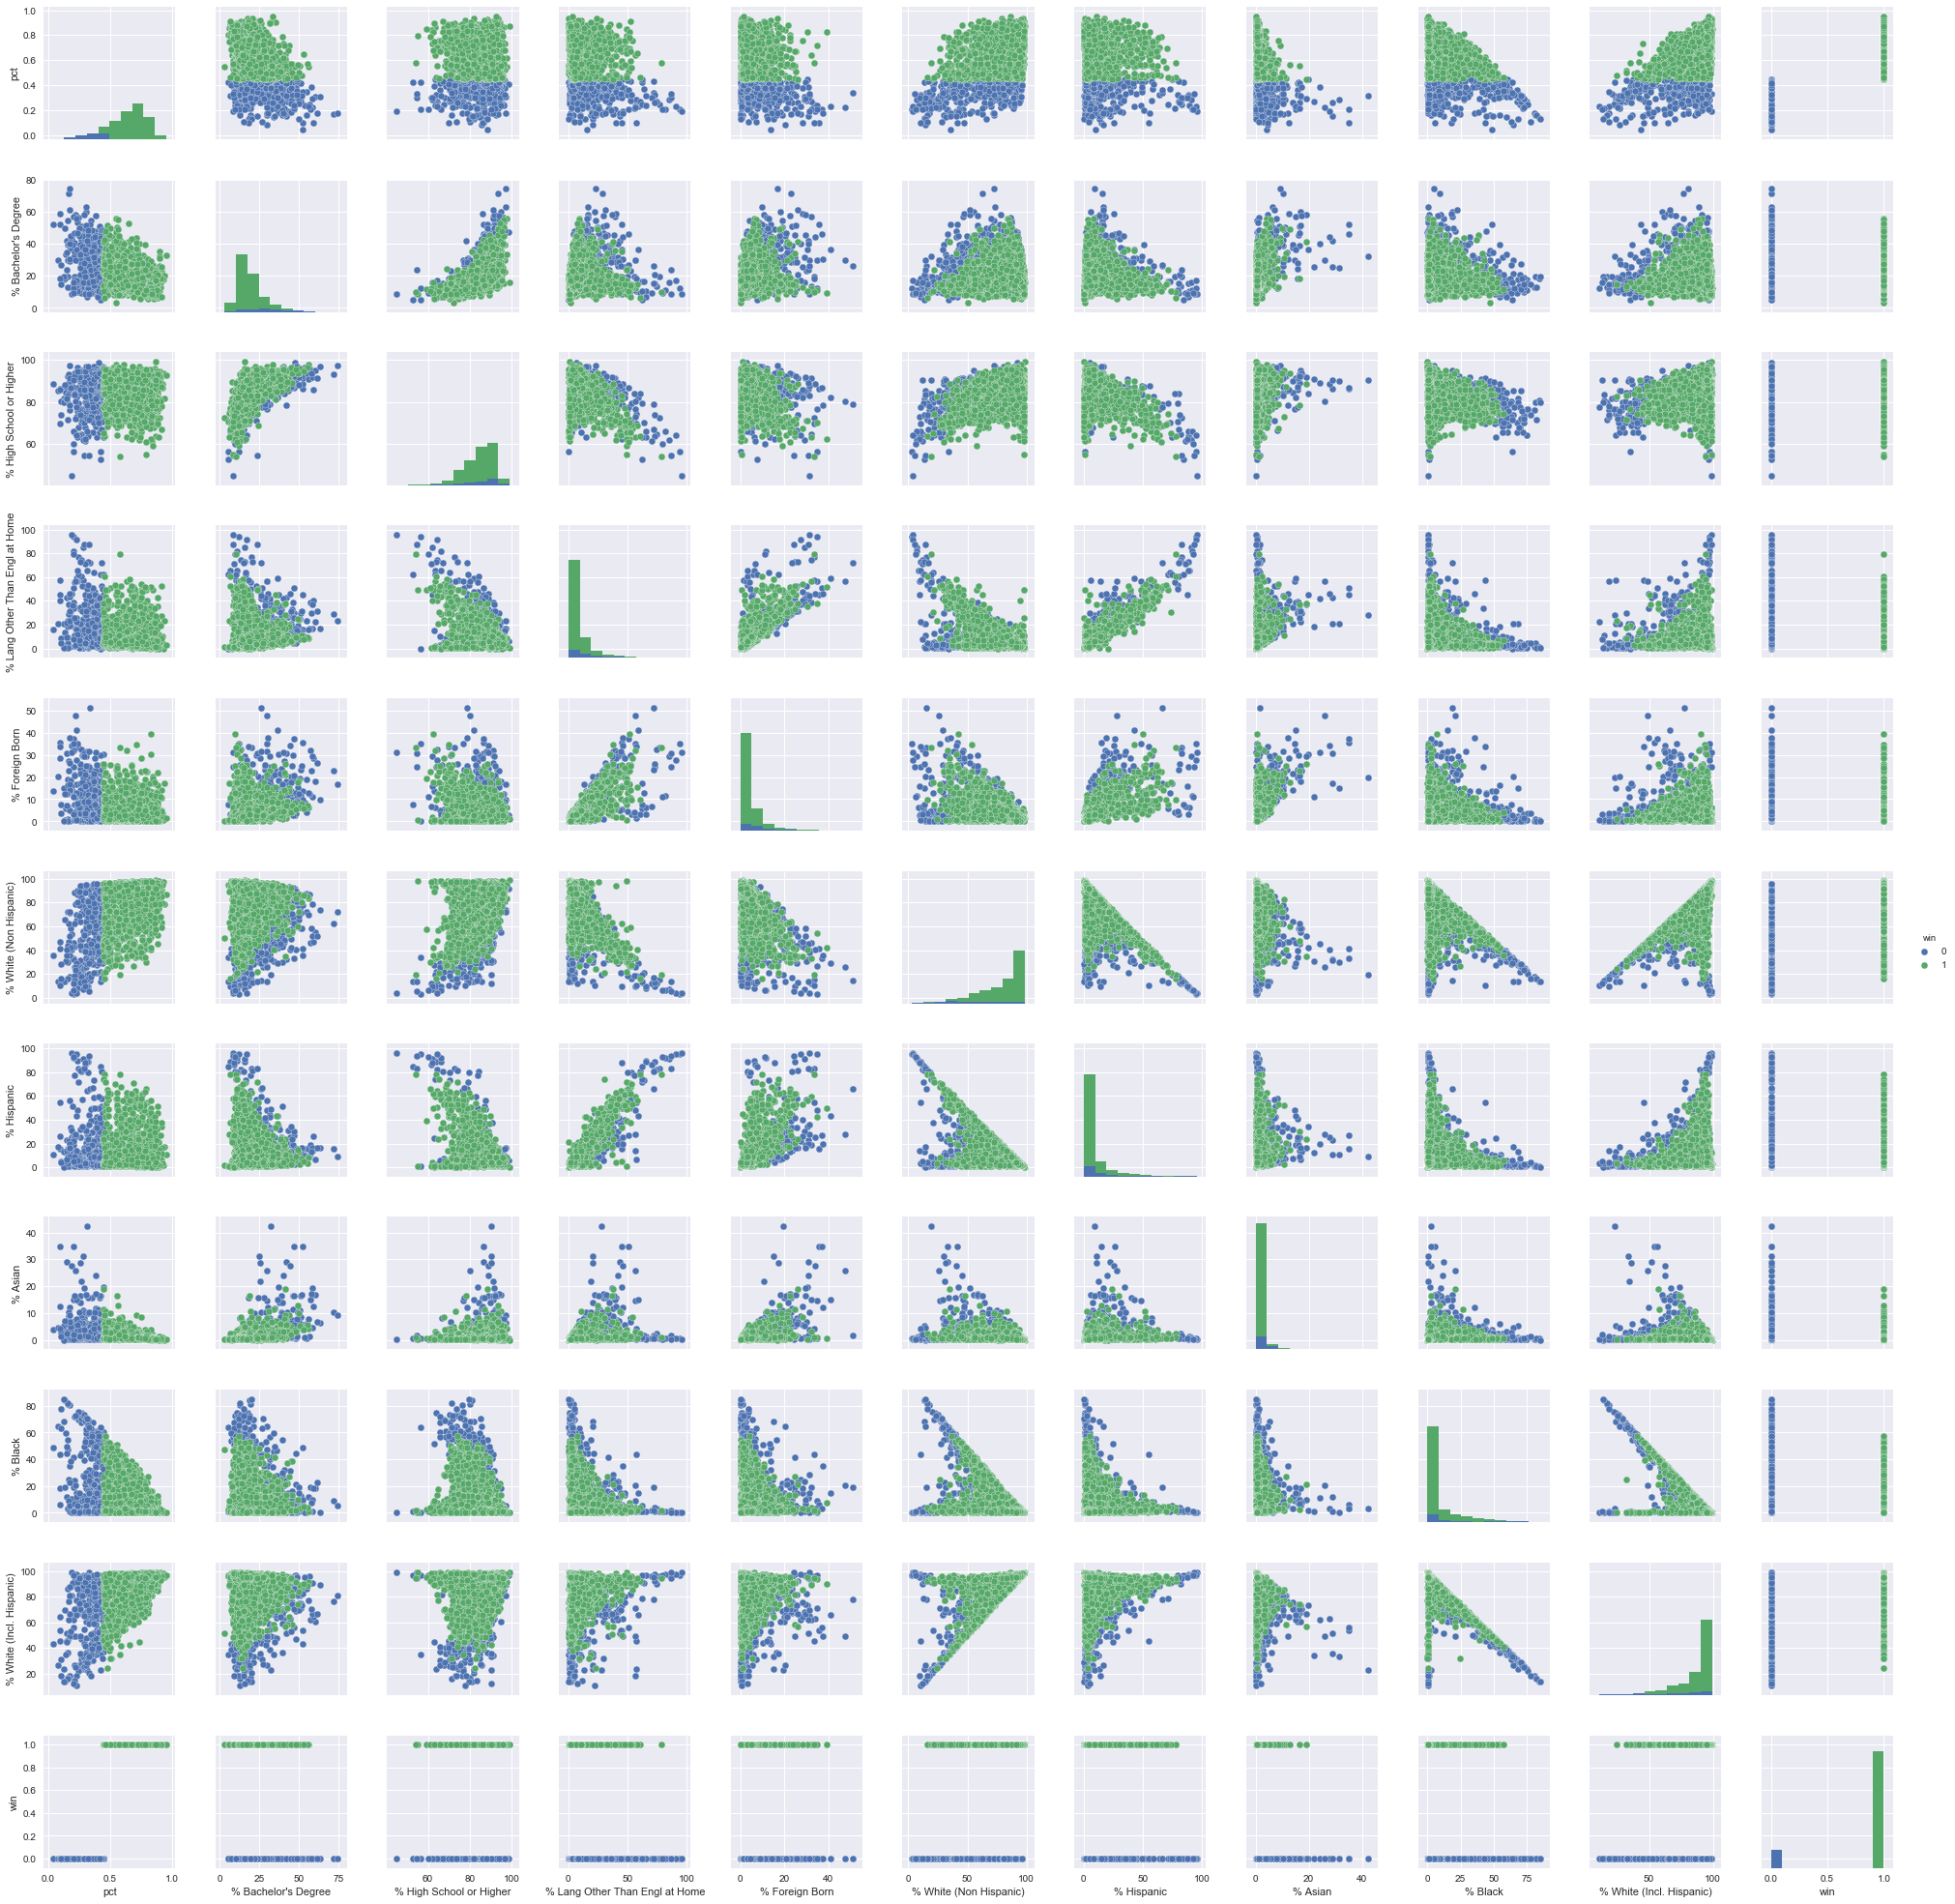

In [114]:
sns.pairplot(trump, hue = 'win')

Preparing data for Machine Learning

In [104]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
train, test = train_test_split(trump, test_size = 0.3)

X_test = test.ix[:,1:-1]
X_train = train.ix[:,1:-1]

# scaling the data
#X_test = preprocessing.scale(X_test)
#X_train = preprocessing.scale(X_train)

# normalizing the data
X_test_norm = preprocessing.normalize(X_test)
X_train_norm = preprocessing.normalize(X_train)

y_test = test[['win']]
y_train = train[['win']]

## Machine Learning

### Decision Tree Model

In [112]:
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print(model)

# make predictions
expected = y_test
predicted = model.predict(X_test)

# summarize the fit of the model
predicted_train = model.predict(X_train)

print('\n---------------------------------')
print('Training Score')
print(metrics.accuracy_score(y_train, predicted_train))
print(metrics.classification_report(y_train, predicted_train))
print(metrics.confusion_matrix(y_train, predicted_train))
print('\n---------------------------------')
print('Test Score')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print('\n---------------------------------')
print('Feature Importance: ')
print(model.feature_importances_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

---------------------------------
Training Score
1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       289
          1       1.00      1.00      1.00      1889

avg / total       1.00      1.00      1.00      2178

[[ 289    0]
 [   0 1889]]

---------------------------------
Test Score
0.901498929336
             precision    recall  f1-score   support

          0       0.64      0.66      0.65       129
          1       0.95      0.94      0.94       805

avg / total       0.90      0.90      0.90       934

[[ 85  44]
 [ 48 757]]

---------------------------------
Feature Importance: 
[ 0.24417213  0.02414332  0.03863366 

### Random Forest Model

In [106]:
from sklearn.ensemble import RandomForestClassifier 

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
print(model)
expected = y_test
predicted = model.predict(X_test)

predicted_train = model.predict(X_train)

print('\n---------------------------------')
print('Training Score')
print(metrics.accuracy_score(y_train, predicted_train))
print(metrics.classification_report(y_train, predicted_train))
print(metrics.confusion_matrix(y_train, predicted_train))
print('\n---------------------------------')
print('Test Score')
print(metrics.accuracy_score(expected, predicted))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print('\n---------------------------------')
print('Feature Importance: ')
print(model.feature_importances_)

/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
---------------------------------
Training Score
1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       289
          1       1.00      1.00      1.00      1889

avg / total       1.00      1.00      1.00      2178

[[ 289    0]
 [   0 1889]]
---------------------------------
Test Score
0.926124197002
             precision    recall  f1-score   support

          0       0.78      0.65      0.71       129
          1       0.95      0.97      0.96       805

avg / total       0.92      0.93      0.92       934

[[ 84  45]
 [ 24 781]]
-----------------------

### Logistic Regression


In [111]:
# Import necessary packages for Logistic Regression

from sklearn import linear_model, datasets
from sklearn.model_selection import cross_val_score

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)
print(model)

# make predictions
expected = y_test
predicted = logistic.predict(X_test)
predicted_train = logistic.predict(X_train)

# summarize the fit of the model

print('\nScore for the Training Set:')
print(model.score(X_test, y_test))
print('\nScore for the Test Set:')
print(model.score(X_train, y_train))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Score for the Training Set:
0.923982869379

Score for the Test Set:
0.931129476584
             precision    recall  f1-score   support

          0       0.80      0.60      0.68       129
          1       0.94      0.98      0.96       805

avg / total       0.92      0.92      0.92       934

[[ 77  52]
 [ 19 786]]


### k-Nearest Neighbours

In [120]:
from sklearn.neighbors import KNeighborsClassifier

# fit data to k-Nearest Neighbor (kNN) model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model

print('\nScore for the Training Set:')
print(model.score(X_test, y_test))
print('\nScore for the Test Set:')
print(model.score(X_train, y_train))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Score for the Training Set:
0.918629550321

Score for the Test Set:
0.951790633609
             precision    recall  f1-score   support

          0       0.78      0.57      0.66       129
          1       0.93      0.97      0.95       805

avg / total       0.91      0.92      0.91       934

[[ 74  55]
 [ 21 784]]


/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In case of many dimension in the feature space (in this case 10), problems can occur while using the k-nearest neighbours algorithm due to the curse of dimensionality (data become sparse if spread out in many dimensions). Therefore, it is sometimes useful to perform dimensionality reduction:

IndexError: too many indices for array

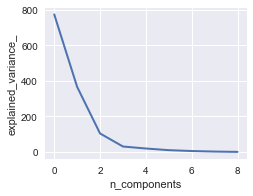

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

pca = decomposition.PCA()

model = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca', pca), ('kNN', model)])

pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

n_components = [2, 3, 4]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

### 93% is already a very good score. Let's see if we can improve our prediction by doing a little bit selecting our features a little bit more careful. 

% By looking at Figures 1 and 2, we can see that feature like %-High School Graduates does not have a 

# Conclusions
Using logistic regression to classify this data set yields a further improvement compared to random forests, with a precision and accuracy of both 95%.

In summary logistic regression performs best in this case of classifying breast cancer samples based on the qualities of cell nuclei from fine needle aspirates of breast mass.